C:\Users\AlbinXavier\AppData\Local\Temp\ipykernel_3708\2153866790.py:8: DtypeWarning: Columns (29) have mixed types. Specify dtype option on import or set low_memory=False.
  ivs = pd.read_csv("../datasets/visitor_survey.csv", parse_dates=["date"])
c:\Users\AlbinXavier\personal\gowtham\nz-tourism\.venv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency QE-DEC will be used.
  self._init_dates(dates, freq)
c:\Users\AlbinXavier\personal\gowtham\nz-tourism\.venv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency QE-DEC will be used.
  self._init_dates(dates, freq)
c:\Users\AlbinXavier\personal\gowtham\nz-tourism\.venv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency QE-DEC will be used.
  self._init_dates(dates, freq)
c:\Users\AlbinXavier\personal\g


[ARIMA(0,1,0) with drift] Hold-out accuracy
   RMSE   : 66.434
   MAE    : 66.434
   MAPE%  : 1.348
   sMAPE% : 1.339
[ARIMA(0,1,0) with drift] AIC: 165.425

Forecast results saved to: ../output/Model_03_ARIMA_IVS_AvgSpend.csv


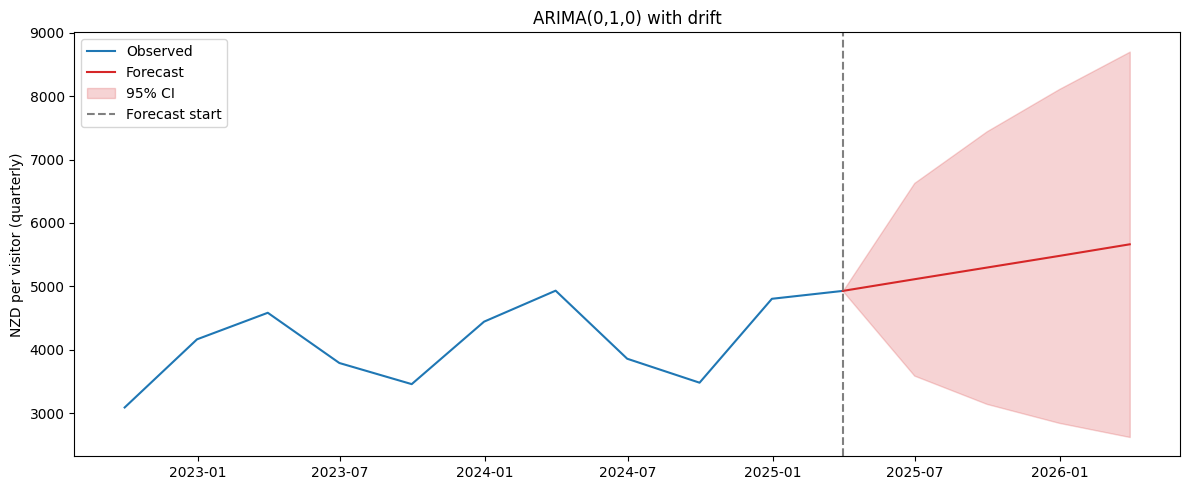

In [7]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from statsmodels.tsa.arima.model import ARIMA


# ============== Data ==============
ivs = pd.read_csv("../datasets/visitor_survey.csv", parse_dates=["date"])
ivs["treated_spend"]  = pd.to_numeric(ivs["treated_spend"], errors="coerce")
ivs["vem_pop_weight"] = pd.to_numeric(ivs["vem_pop_weight"], errors="coerce")

ivs_q = (
    ivs.groupby("date")[["treated_spend", "vem_pop_weight"]]
    .apply(lambda g: np.average(g["treated_spend"], weights=g["vem_pop_weight"]))
    .reset_index(name="avg_spend")
).set_index("date").sort_index()

y = ivs_q["avg_spend"].astype(float)


# ============== Metrics ==============
def _metrics(y_true: pd.Series, y_pred: pd.Series):
    y_true, y_pred = y_true.align(y_pred, join="inner")
    a, f = y_true.values.astype(float), y_pred.values.astype(float)

    rmse = np.sqrt(np.mean((f - a) ** 2))
    mae  = np.mean(np.abs(f - a))
    mape = np.mean(np.abs((f[a!=0] - a[a!=0]) / a[a!=0])) * 100 if (a!=0).any() else np.nan
    smape = (2*np.mean(np.abs(f-a)/(np.abs(a)+np.abs(f))))*100 if (np.abs(a)+np.abs(f)).any() else np.nan
    return {"RMSE": rmse, "MAE": mae, "MAPE%": mape, "sMAPE%": smape}

def _print_metrics(title: str, m: dict):
    print(f"\n[{title}] Hold-out accuracy")
    for k,v in m.items():
        print(f"   {k:7}: {v:,.3f}" if np.isfinite(v) else f"   {k:7}: nan")


# ============== ARIMA Forecast ==============
def arima_forecast(y, order=(0,1,0), trend="t", k_test=4, h_future=8, title="ARIMA Forecast"):
    # --- Split
    y_train, y_test = y.iloc[:-k_test], y.iloc[-k_test:]

    # --- Train-only model for test forecast
    res_train = ARIMA(y_train, order=order, trend=trend).fit()
    fc_test = res_train.get_forecast(steps=k_test)
    y_pred_test = fc_test.predicted_mean
    metrics = _metrics(y_test, y_pred_test)
    _print_metrics(title, metrics)

    # --- Full-data model for future forecast
    res_full = ARIMA(y, order=order, trend=trend).fit()
    print(f"[{title}] AIC: {res_full.aic:.3f}")

    fc_future = res_full.get_forecast(steps=h_future)
    y_pred_future = fc_future.predicted_mean
    ci_future     = fc_future.conf_int()

    # --- Extend forecast + CI to connect with last observed
    forecast_line = pd.concat([y.iloc[[-1]], y_pred_future])
    ci_future_ext = ci_future.copy()
    ci_future_ext.loc[y.index[-1]] = [y.iloc[-1], y.iloc[-1]]
    ci_future_ext = ci_future_ext.sort_index()

    # --- Save forecast results to CSV
    out_csv = "../output/Model_03_ARIMA_IVS_AvgSpend.csv"
    df_out = pd.DataFrame({
        "Observed": y.reindex(forecast_line.index),
        "Forecast": forecast_line,
        "Lower_CI": ci_future_ext.iloc[:,0],
        "Upper_CI": ci_future_ext.iloc[:,1],
    })
    df_out.index.name = "Date"
    df_out.to_csv(out_csv)
    print(f"\nForecast results saved to: {out_csv}")

    # --- Plot
    plt.figure(figsize=(12,5))
    plt.plot(y.index, y, label="Observed", color="tab:blue")
    plt.plot(forecast_line.index, forecast_line.values, label="Forecast", color="tab:red")
    plt.fill_between(ci_future_ext.index,
                     ci_future_ext.iloc[:,0], ci_future_ext.iloc[:,1],
                     color="tab:red", alpha=0.2, label="95% CI")

    plt.axvline(y.index[-1], color="gray", linestyle="--", label="Forecast start")
    plt.title(title)
    plt.ylabel("NZD per visitor (quarterly)")
    plt.legend()
    plt.tight_layout()
    plt.show()


# ============== Run ==============
arima_forecast(
    y,
    order=(0,1,0),
    trend="t",
    k_test=min(4, max(1, len(y)//6)),
    h_future=4,
    title="ARIMA(0,1,0) with drift"
)
